In [72]:
import numpy as np

import os ,sys

import random

import matplotlib.pyplot as plt

import pandas as pd

import copy


from matplotlib.ticker import MultipleLocator, FormatStrFormatter


import scipy.stats as stats

In [73]:
Estimate_Path='./Data/Estimation/'

Collect_Path='./Data/Collection/'

Valicate_Path='./Data/Prediction/'

Labels=['A','B','C']

The_number_of_Shifts=np.load(os.path.join(Estimate_Path,'The_number_of_Shifts.npy')).item()

First_shift_start_time=np.load(os.path.join(Estimate_Path,'First_shift_start_time.npy')).item()

Duration_discrete_Param=np.load(os.path.join(Estimate_Path,'Duration_discrete_Param.npy')).item()

Gap_discrete_Param=np.load(os.path.join(Estimate_Path,'Gap_discrete_Param.npy')).item()

Clustered_DF=pd.read_csv(os.path.join(Collect_Path,'Clustered_DF.csv'))

Clustered_DF=Clustered_DF.drop(columns=['Unnamed: 0'])

Driver_DF=Clustered_DF[['Driver_id','label']]

Driver_DF=Driver_DF.drop_duplicates(subset=['Driver_id','label'])

Valicate_DF=pd.read_csv(os.path.join(Valicate_Path,'Validation.csv'))

Valicate_DF=Valicate_DF.drop(columns=['Unnamed: 0'])


dt=20161114

Valicate_DF=Valicate_DF.loc[Valicate_DF['date']==dt]

Count_Stat=Clustered_DF.loc[Clustered_DF['date']==dt].groupby('label').count()

Count_Stat['label']=Count_Stat.index

Count_Stat=Count_Stat[['label','Driver_id']]

Count_Stat=Count_Stat.rename(columns={'Driver_id':'Driver_Num'})

Count_Stat=Count_Stat.reset_index(drop=True)

Driver_count={}


for idx,row in Count_Stat.iterrows():
    
    label=row['label']
    
    num=row['Driver_Num']
    
    Driver_count[label]=num

Driver_count


{'A': 18823, 'B': 12887, 'C': 5230}

## 01 Sample the number of shifts

In [74]:
'''Shifts quantity'''

def Random_pick(distribution,driver_count,cluster):
    
    num=driver_count[cluster]
    
    dic=distribution[cluster]
    
    return np.array([np.random.choice(list(dic.keys()),p=list(dic.values())) for i in range(num)])

shiftNum_A=Random_pick(The_number_of_Shifts,Driver_count,'A')

shiftNum_B=Random_pick(The_number_of_Shifts,Driver_count,'B')

shiftNum_C=Random_pick(The_number_of_Shifts,Driver_count,'C')

Shifts_Num={'A':{i:shiftNum_A[i] for i in range(Driver_count['A'])},\
            'B':{j:shiftNum_B[j] for j in range(Driver_count['B'])},\
            'C':{k:shiftNum_C[k] for k in range(Driver_count['C'])}}

## 02 First shift start time

In [75]:
'''First Shift Start Hour'''

class Sampling(object):
    
    def __init__(self,Param):
        
        self.modal=int((len(Param)-2)/3)
        
        self.mu=list()
        
        self.sigma=list()
        
        self.A=list()
        
        for i in range(self.modal):
            
            self.mu.append(Param['mu'+str(i+1)])
            
            self.sigma.append(Param['sigma'+str(i+1)])
            
            self.A.append(Param['A'+str(i+1)])
            
        self.min_=round(Param['min'],2)
        
        self.max_=round(Param['max'],2)+0.01

    def gauss(self,x,mu,sigma,A):
        
        return A*np.exp(-(x-mu)**2/2/sigma**2)*(1/np.sqrt(2*np.pi)/sigma)
    
    def Multi_Modal(self,x):
        
        num=0
        
        for i in range(self.modal):
            
            num+=self.gauss(x,self.mu[i],self.sigma[i],self.A[i])
            
        return num

    
    def discrete_sampler(self,quantity):
        
        Samples_dic={}
        
        for x in np.arange(self.min_,self.max_,0.01):

            r=self.Multi_Modal(x)

            Samples_dic[x]=r
            
        Norm=sum(Samples_dic.values())

        Samples_dic={k:v/Norm for k,v in Samples_dic.items()}
        
        arr=[np.random.choice(list(Samples_dic.keys()),p=list(Samples_dic.values())) for i in range(quantity)]
        
        return arr

Samp=Sampling(First_shift_start_time['A'])

First_Shift_Start_Hour_A=Samp.discrete_sampler(Driver_count['A'])

Samp=Sampling(First_shift_start_time['B'])

First_Shift_Start_Hour_B=Samp.discrete_sampler(Driver_count['B'])

Samp=Sampling(First_shift_start_time['C'])

First_Shift_Start_Hour_C=Samp.discrete_sampler(Driver_count['C'])

Shifts={'A':{i:{'Start':[First_Shift_Start_Hour_A[i]],'End':[]} for i in range(Driver_count['A'])},\
        'B':{j:{'Start':[First_Shift_Start_Hour_B[j]],'End':[]} for j in range(Driver_count['B'])},\
        'C':{k:{'Start':[First_Shift_Start_Hour_C[k]],'End':[]} for k in range(Driver_count['C'])}}

## 03  Shift Duration and  Gap between two shifts

In [76]:
'''Truncted Gaussian Sampler'''

def Truncted_sampler(mu, sigma, lower, upper):

    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    
    sampler=X.rvs(1)[0]
    
    return sampler

def Gamma_sampler(mu, sigma, lower, upper):
    
    g_alpha = mu*mu/sigma
    
    g_beta = mu/sigma
    
    sampler=random.gammavariate(g_alpha,1/g_beta)
    
    while sampler<lower or sampler>upper:
        
        sampler=random.gammavariate(g_alpha,1/g_beta)
        
    return sampler

for cluster,shifts in Shifts.items():
    
    for driver_id in shifts.keys():
        
        if driver_id%5000==0:
        
            print(cluster,driver_id)
        
        shift_num=Shifts_Num[cluster][driver_id]
        
        while True:
            
            Start_time=Shifts[cluster][driver_id]['Start'][-1]
                 
            Start_hour=round(Start_time,1)
            
            if Duration_discrete_Param[cluster][Start_hour]['mean']!=0 and Duration_discrete_Param[cluster][Start_hour]['std']!=0:
            
                duration=Gamma_sampler(Duration_discrete_Param[cluster][Start_hour]['mean'],\
                                          Duration_discrete_Param[cluster][Start_hour]['std'],\
                                          Duration_discrete_Param[cluster][Start_hour]['min'],\
                                          Duration_discrete_Param[cluster][Start_hour]['max'])
                
            else:
                
                duration=0.1

                
            Shifts[cluster][driver_id]['End'].append(Start_time+duration)
                
            if len(Shifts[cluster][driver_id]['End'])==shift_num:
                    
                break
                    
            End_Time=Shifts[cluster][driver_id]['End'][-1]

            End_hour=round(End_Time,1)
            
            if End_Time>24.0:
                    
                break

            if Gap_discrete_Param[cluster][End_hour]['mean']!=0 and Gap_discrete_Param[cluster][End_hour]['std']!=0:

                gap=Gamma_sampler(Gap_discrete_Param[cluster][End_hour]['mean'],\
                                     Gap_discrete_Param[cluster][End_hour]['std'],\
                                     Gap_discrete_Param[cluster][End_hour]['min'],\
                                     Gap_discrete_Param[cluster][End_hour]['max'])
            else:

                gap=2


            if End_Time+gap>24.0:
                    
                break
                    
            else:

                Shifts[cluster][driver_id]['Start'].append(End_Time+gap)

A 0
A 5000
A 10000
A 15000
B 0
B 5000
B 10000
C 0
C 5000


## 04 Statistics

In [77]:
def explode(df, col):
    df[col] = df[col].apply(lambda x: [x] if not isinstance(x, list) else x)
    return df.drop(col, axis=1).join(
        pd.DataFrame(list(df[col])).stack().reset_index(level=1, drop=True).rename(col)
    ) 


Pred_df=pd.DataFrame([],columns=['label','Start','End'])

for cluster in Labels:

    df=pd.DataFrame(Shifts[cluster].values())
    
    df['label']=cluster
    
    df=df[['label','Start','End']]
    
    Pred_df=pd.concat([Pred_df,df],ignore_index=True)
    

Pred_df['Transition']=Pred_df.apply(lambda x: [(x['Start'][i],x['End'][i]) for i in range(len(x['Start']))],axis=1)

Pred_df=Pred_df[['label','Transition']]

Pred_df=explode(Pred_df,'Transition')

Pred_df['Start']=Pred_df.apply(lambda x:round(x['Transition'][0],1),axis=1)

Pred_df['End']=Pred_df.apply(lambda x:round(x['Transition'][1],1),axis=1)

Pred_df['Active_range']=Pred_df.apply(lambda x:[round(y,1) for y in np.arange(x['Start'],x['End']+0.1,0.1)],axis=1)

Pred_df=Pred_df[['label','Active_range','Start']]

Pred_df=Pred_df.reset_index(drop=True)

Pred_df=explode(Pred_df,'Active_range')

Pred_df=Pred_df.rename(columns={'Active_range':'step'})

Pred_df=Pred_df.groupby(['step','label']).count()

Pred_df=Pred_df[['Start']]

Pred_df=Pred_df.rename(columns={'Start':'Pred'})

Pred_df['Transition']=Pred_df.index

Pred_df['step']=Pred_df.apply(lambda x:x['Transition'][0],axis=1)

Pred_df['label']=Pred_df.apply(lambda x:x['Transition'][1],axis=1)

Pred_df=Pred_df.reset_index(drop=True)

Pred_df=Pred_df[['label','step','Pred']]

Pred_df=Pred_df.loc[Pred_df['step']<=24.0]

Pred_df


,label,step,Pred
0,A,0.1,228
1,A,0.2,638
2,A,0.3,1106
3,A,0.4,1429
4,C,0.4,9
5,A,0.5,1608
6,C,0.5,23
7,A,0.6,1662
8,C,0.6,32
9,A,0.7,1670


In [78]:
Stat_Df=pd.read_csv(os.path.join(Valicate_Path,'Stat_Df'+str(dt)+'.csv'))

Stat_Df=Stat_Df.drop(columns=['Unnamed: 0'])

Stat_Df=Stat_Df.merge(Driver_DF,on='Driver_id')

Stat_Df=Stat_Df.groupby(['step','label']).count()

Stat_Df=Stat_Df[['Driver_id']]

Stat_Df=Stat_Df.rename(columns={'Driver_id':'Count'})

Stat_Df['Transition']=Stat_Df.index

Stat_Df['step']=Stat_Df.apply(lambda x:x['Transition'][0],axis=1)

Stat_Df['label']=Stat_Df.apply(lambda x:x['Transition'][1],axis=1)

Stat_Df=Stat_Df.reset_index(drop=True)

Stat_Df=Stat_Df[['label','step','Count']]

Stat_Df=Stat_Df.merge(Pred_df,on=['label','step'],how='left')

Stat_Df=Stat_Df.fillna(0)

Stat_Df=Stat_Df.loc[(Stat_Df['step']>0.0)&(Stat_Df['step']<24.1)]

Stat_Df



,label,step,Count,Pred
2,A,0.1,320,228.0
3,C,0.1,16,0.0
4,A,0.2,842,638.0
5,C,0.2,34,0.0
6,A,0.3,1177,1106.0
7,C,0.3,54,0.0
8,A,0.4,1463,1429.0
9,C,0.4,64,9.0
10,A,0.5,1469,1608.0
11,C,0.5,70,23.0


In [79]:
Overall_Df=copy.deepcopy(Stat_Df)

Overall_Df=Overall_Df.groupby('step').sum()

Overall_Df['step']=Overall_Df.index

Overall_Df=Overall_Df.reset_index(drop=True)

Overall_Df=Overall_Df[['step','Count','Pred']]

Overall_Df


,step,Count,Pred
0,0.1,336,228.0
1,0.2,876,638.0
2,0.3,1231,1106.0
3,0.4,1527,1438.0
4,0.5,1539,1631.0
5,0.6,1649,1694.0
6,0.7,1572,1710.0
7,0.8,1618,1718.0
8,0.9,1582,1784.0
9,1.0,1520,1738.0


## 05 Visualization

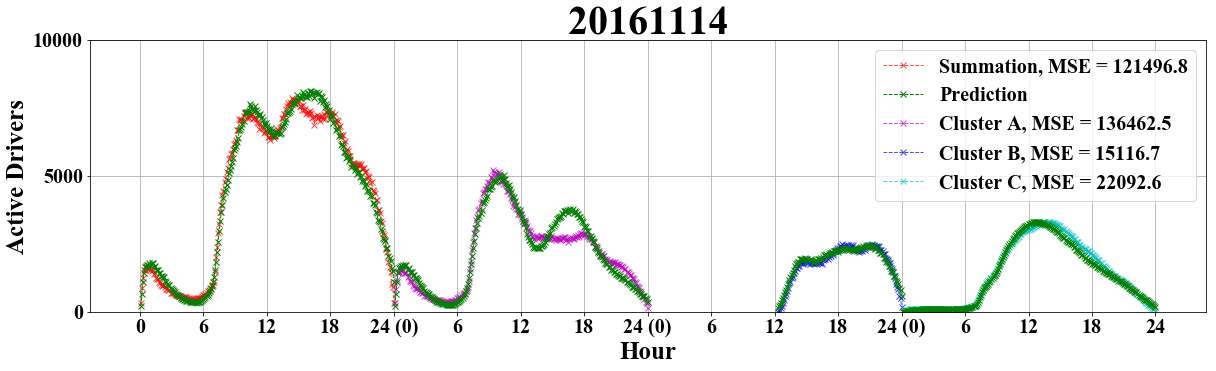

In [80]:
def MSE(y_test, y_predict):
    mean_squared_error = sum( (y_test - y_predict)**2) / len(y_test)
    return mean_squared_error





'''Plot Figure'''

figsize = 20,5

font_title = {'family' : 'Times New Roman','weight' : 'normal','size': 40}

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

'''Overall'''

steps=np.array(list(Overall_Df['step']))

Counts=np.array(list(Overall_Df['Count']))

Preds=np.array(list(Overall_Df['Pred']))

mse=MSE(Counts,Preds)


ax1.plot(steps,\
         Counts,\
         'r--',\
         linewidth=1,\
         marker='x',\
         label='Summation, MSE = '+str(round(mse,1)),\
         alpha=0.7)

ax1.plot(steps, Preds, 'g--',linewidth=1,marker='x', label='Prediction',alpha=1)


'''Discrete'''

colors=['m','b','c']

for i in range(len(Labels)):
    
    label=Labels[i]
    
    steps=np.array(Stat_Df.loc[Stat_Df['label']==label,'step'])
    
    Counts=np.array(Stat_Df.loc[Stat_Df['label']==label,'Count'])
    
    Preds=np.array(Stat_Df.loc[Stat_Df['label']==label,'Pred'])
    
    mse=MSE(Counts,Preds)
    
    ax1.plot(steps+(i+1)*24.0,\
             Counts,\
             colors[i]+'--',\
             linewidth=1,\
             marker='x',\
             label='Cluster '+label+', MSE = '+str(round(mse,1)),\
             alpha=0.7)
    


    ax1.plot(steps+(i+1)*24.0, Preds, 'g--',linewidth=1,marker='x',alpha=1)


ax1.set_ylabel('Active Drivers',font_label)

ax1.set_xlabel('Hour',font_label)

ax1.legend(loc = 'upper right',prop=font_legend)

ax1.set_ylim([0,10000])

xmajorLocator   = MultipleLocator(6)

ax1.xaxis.set_major_locator(xmajorLocator)

ymajorLocator   = MultipleLocator(5000)

ax1.yaxis.set_major_locator(ymajorLocator) 

ax1.set_xticklabels(['','0', '6','12', '18','24 (0)', '6','12', '18','24 (0)','6','12', '18','24 (0)','6','12', '18','24'],font_legend)

ax1.set_title(str(dt),font_title)


plt.grid()

plt.show()




